# Determination of the Normalization Constant

In this Notebook we are going to estimate a normalization constant for the pixel intensities of the U-Net inputs.

## Required Libraries and Functions

In [1]:
%matplotlib inline
import sys

# Add library path to PYTHONPATH
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import cadmos_lib as cl
import tensorflow as tf
import galsim
from galsim import Image
import galsim.hsm
import galflow as gf
from galaxy2galaxy import problems

# Functions

def ir2tf_simplifie(imp_resp, shape):
    

    dim = 2
    # Zero padding and fill
    irpadded = np.zeros(shape)
    irpadded[tuple([slice(0, s) for s in imp_resp.shape])] = imp_resp
    # Roll for zero convention of the fft to avoid the phase
    # problem. Work with odd and even size.
    for axis, axis_size in enumerate(imp_resp.shape):

        irpadded = np.roll(irpadded,
                           shift=-int(np.floor(axis_size / 2)),
                           axis=axis)

    return fft.rfftn(irpadded, axes=range(-dim, 0))

def laplacian_simplifie(shape):
    
    impr = np.zeros([3,3])
    for dim in range(2):
        idx = tuple([slice(1, 2)] * dim +
                    [slice(None)] +
                    [slice(1, 2)] * (1 - dim))
        impr[idx] = np.array([-1.0,
                              0.0,
                              -1.0]).reshape([-1 if i == dim else 1
                                              for i in range(2)])
    impr[(slice(1, 2), ) * 2] = 4.0
    return ir2tf_simplifie(impr, shape), impr

def laplacian_tf(shape):
    return tf.convert_to_tensor(laplacian_simplifie(shape)[0])

def wiener_tf(image, psf, balance, laplacian=True):
    r"""Applies Wiener filter to image.

    This function takes an image in the direct space and its corresponding PSF in the
    Fourier space and performs a deconvolution using the Wiener Filter.

    Parameters
    ----------
    image   : 2D TensorFlow tensor
        Image in the direct space.
    psf     : 2D TensorFlow tensor
        PSF in the Fourier space (or K space).
    balance : scalar
        Weight applied to regularization.
    laplacian : boolean
        If true the Laplacian regularization is used else the identity regularization 
        is used.

    Returns
    -------
    tuple
        The first element is the filtered image in the Fourier space.
        The second element is the PSF in the Fourier space (also know as the Transfer
        Function).
    """
    trans_func = psf
    if laplacian:
        reg = laplacian_tf(image.shape)
        if psf.shape != reg.shape:
            trans_func = tf.signal.rfft2d(tf.signal.ifftshift(tf.cast(psf, 'float32')))
        else:
            trans_func = psf
    
    arg1 = tf.cast(tf.math.conj(trans_func), 'complex64')
    arg2 = tf.dtypes.cast(tf.math.abs(trans_func),'complex64') ** 2
    arg3 = balance
    if laplacian:
        arg3 *= tf.dtypes.cast(tf.math.abs(laplacian_tf(image.shape)), 'complex64')**2
    wiener_filter = arg1 / (arg2 + arg3)
    
    # Apply wiener in Foutier (or K) space
    wiener_applied = wiener_filter * tf.signal.rfft2d(tf.cast(image, 'float32'))
    
    return wiener_applied, trans_func

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.

    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # First, we add noise
    # For the estimation of CFHT noise standard deviation check section 3 of:
    # https://github.com/CosmoStat/ShapeDeconv/blob/master/data/CFHT/HST2CFHT.ipynb
    sigma_cfht = 23.59
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma_cfht, dtype=tf.float32)
    dico['inputs'] = dico['inputs'] + noise

    # Second, we interpolate the image on a finer grid
    x_interpolant=tf.image.ResizeMethod.BICUBIC
    interp_factor = 2
    Nx = 64
    Ny = 64
    dico['inputs_cfht'] = tf.image.resize(dico['inputs'],
                    [Nx*interp_factor,
                    Ny*interp_factor],
                    method=x_interpolant)
    # Since we lower the resolution of the image, we also scale the flux
    # accordingly
    dico['inputs_cfht'] = dico['inputs_cfht'] / interp_factor**2

    balance = 9e-3  # determined using line search
    dico['inputs_tikho'], _ = wiener_tf(dico['inputs_cfht'][...,0], dico['psf_cfht'][...,0], balance)
    dico['inputs_tikho'] = tf.expand_dims(dico['inputs_tikho'], axis=0)
    psf_hst = tf.reshape(dico['psf_hst'], [dico['psf_hst'].shape[-1],*dico['psf_hst'].shape[:2]])
    psf_hst = tf.cast(psf_hst, 'complex64')
    # gf.kconvolve performs a convolution in the K (Fourier) space
    # inputs are given in K space
    # the output is in the direct space
    dico['inputs_tikho'] = gf.kconvolve(dico['inputs_tikho'], psf_hst,zero_padding_factor=1,interp_factor=interp_factor)
    dico['inputs_tikho'] = dico['inputs_tikho'][0,...]

    return dico

## Generate The Evaluation Dataset

In [2]:
# Let's create an instance of the hsc_problem
Modes = tf.estimator.ModeKeys
problem128 = problems.problem('attrs2img_cosmos_parametric_cfht2hst')
dset = problem128.dataset(Modes.EVAL, data_dir='/gpfswork/rech/xdy/uze68md/data/attrs2img_cosmos_parametric_cfht2hst/')
dset = dset.repeat()
dset = dset.map(pre_proc_unet)

n_batch = 128

dset = dset.batch(n_batch)


INFO:tensorflow:Reading data files from /gpfswork/rech/xdy/uze68md/data/attrs2img_cosmos_parametric_cfht2hst/attrs2img_cosmos_parametric_cfht2hst-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




## Extract Batches and Concatenate Them

In [3]:
# Build an iterator over the dataset
iterator = dset.make_one_shot_iterator().get_next()
sess = tf.Session()

# Initialize batch
batch = sess.run(iterator)
k_batch = 24 #16

for k in range(k_batch-1):
    # Extract temporary batch
    tmp = sess.run(iterator)
    # Add to batch
    for key in tmp:
        batch[key]=np.concatenate((batch[key],tmp[key]))
sess.close()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


## Plot Galaxy Images

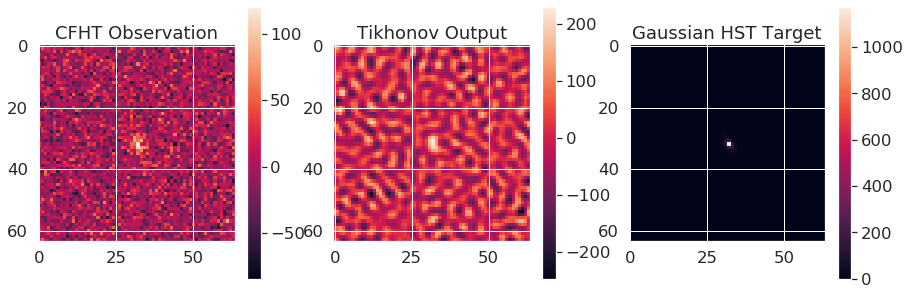

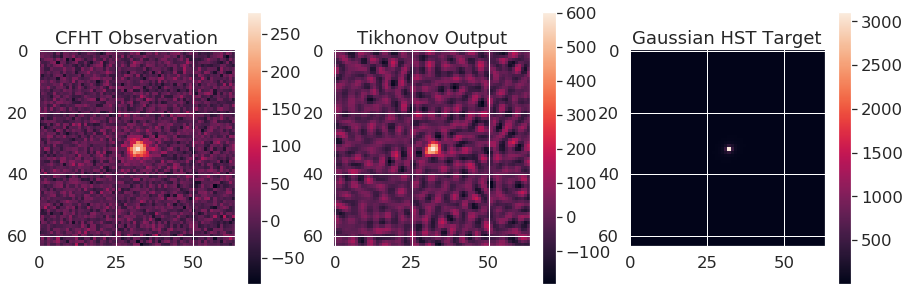

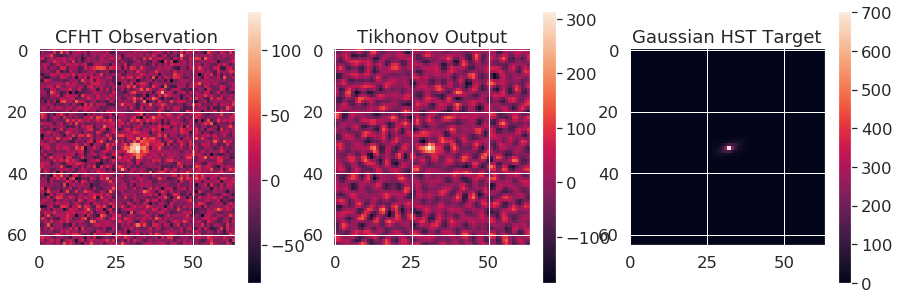

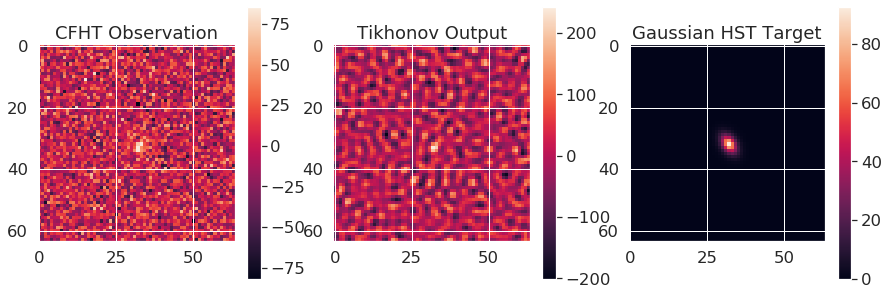

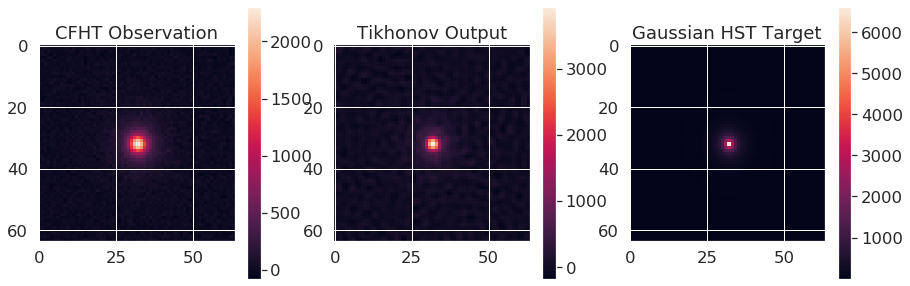

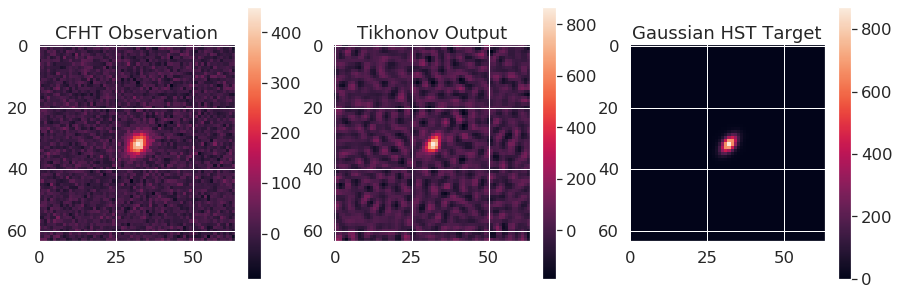

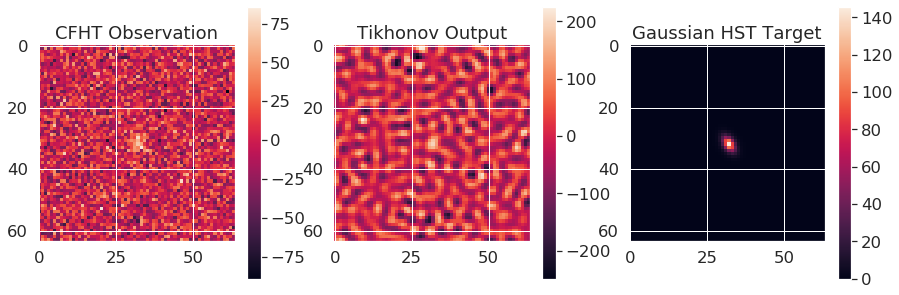

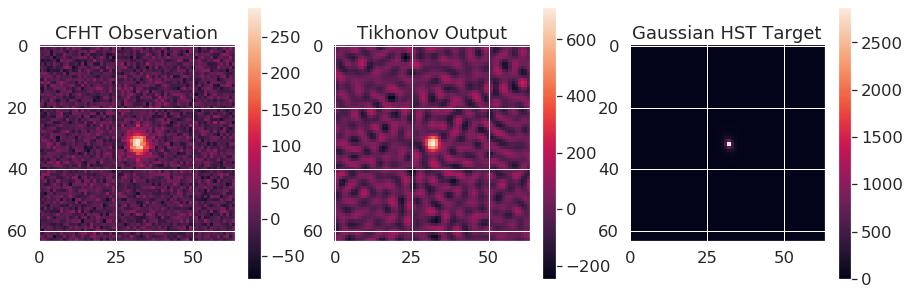

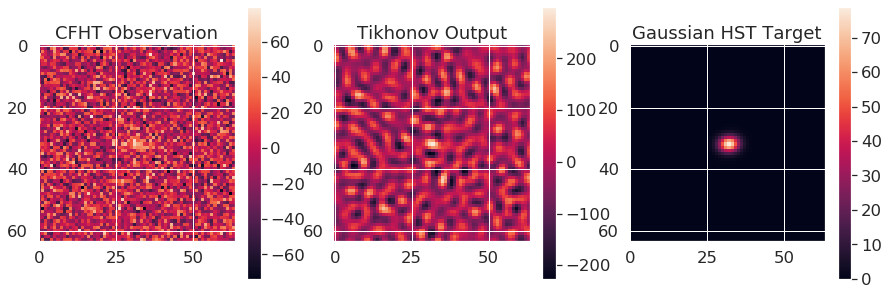

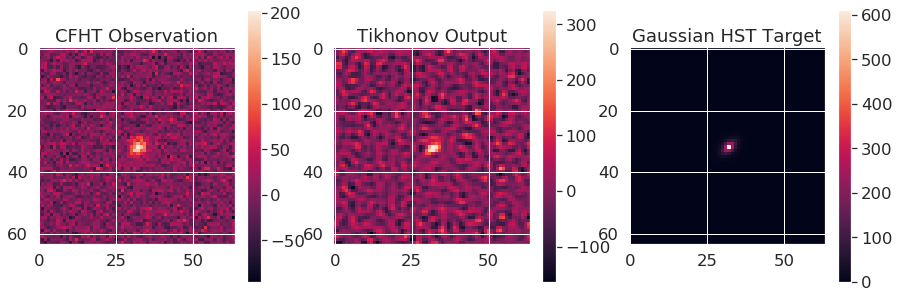

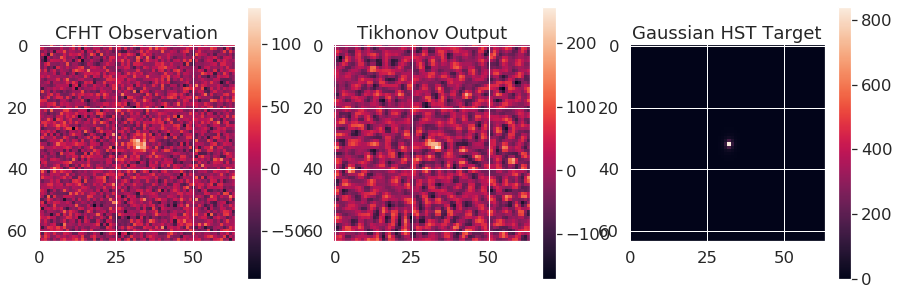

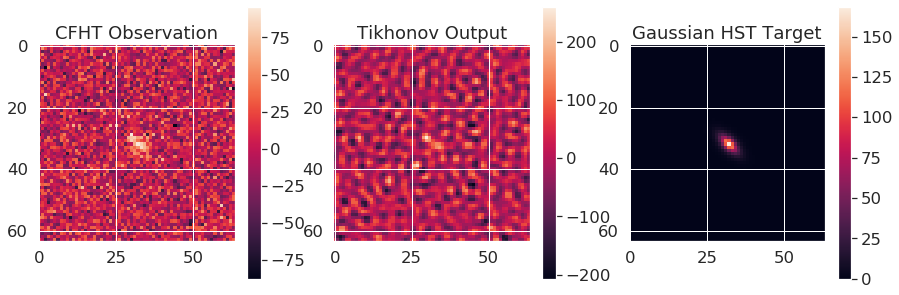

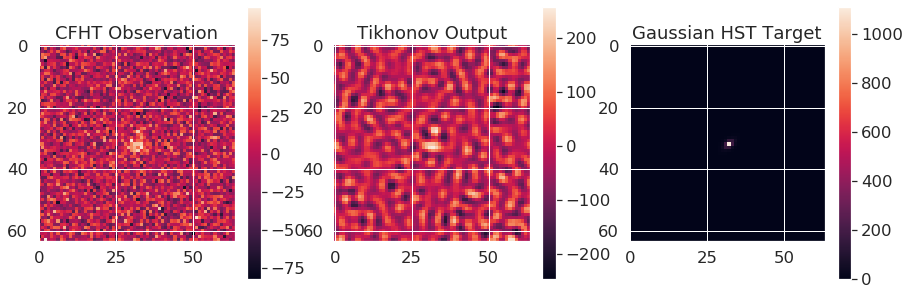

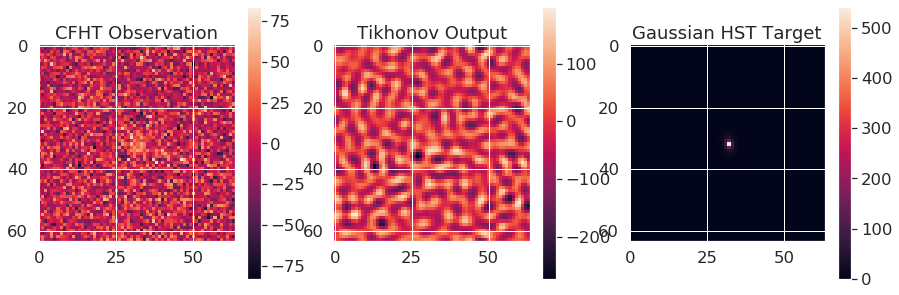

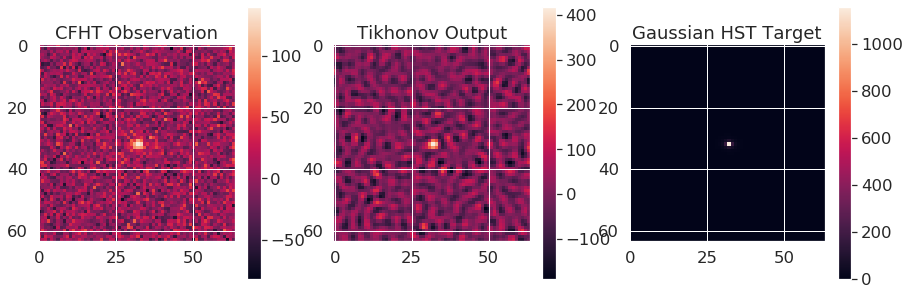

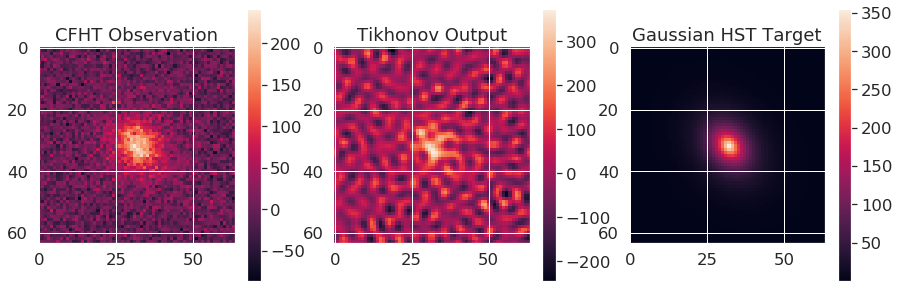

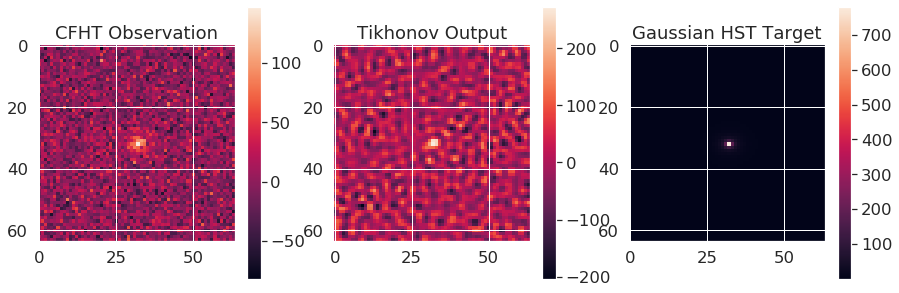

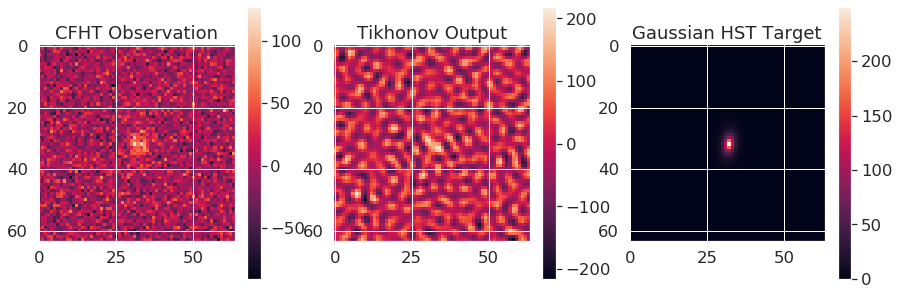

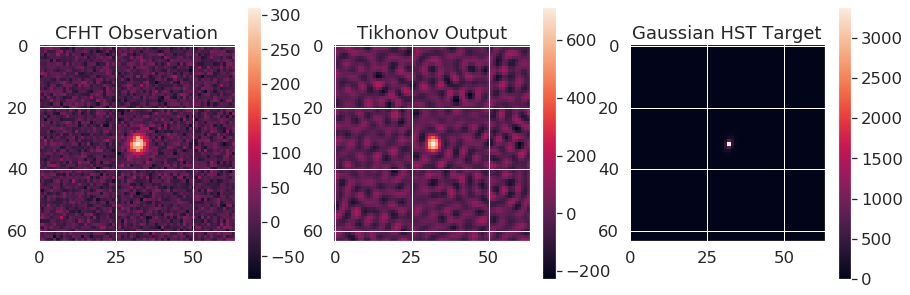

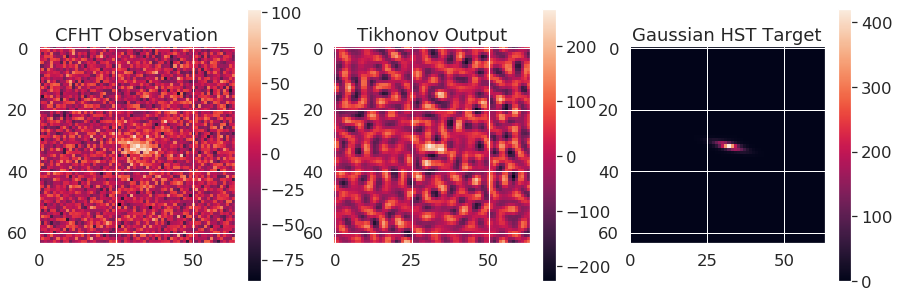

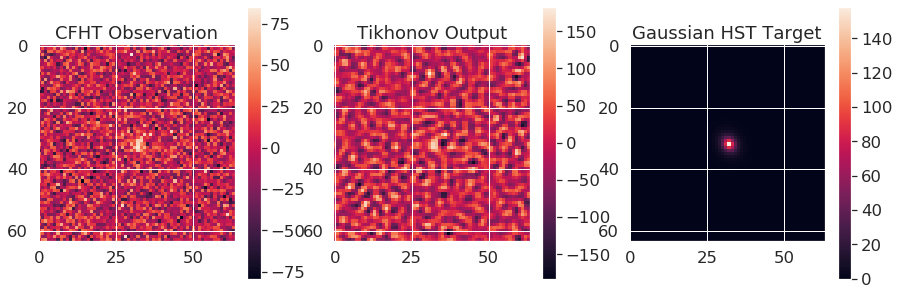

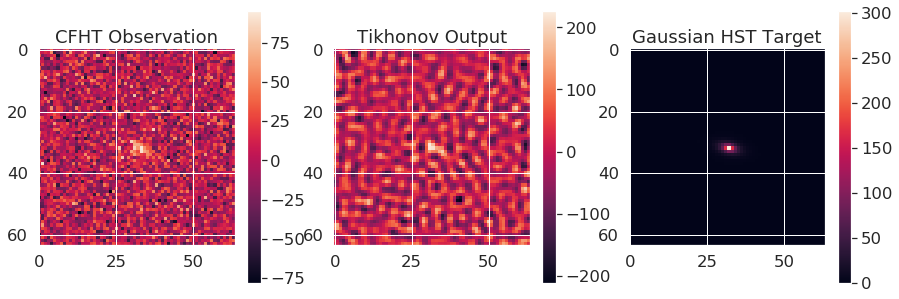

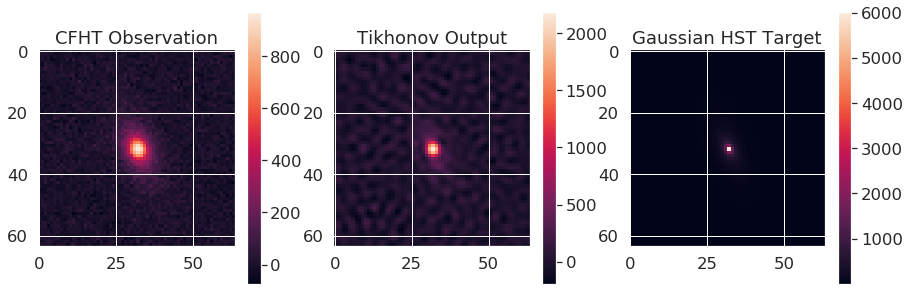

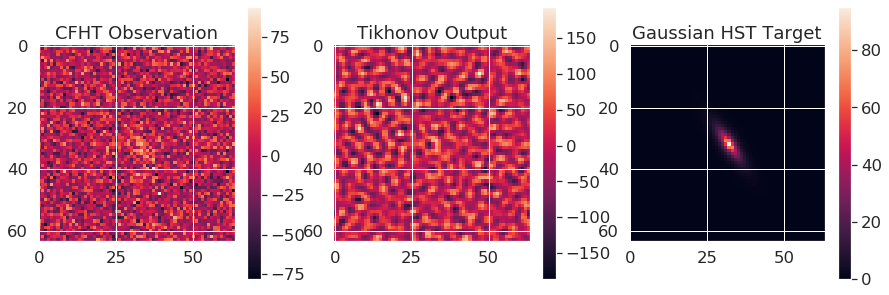

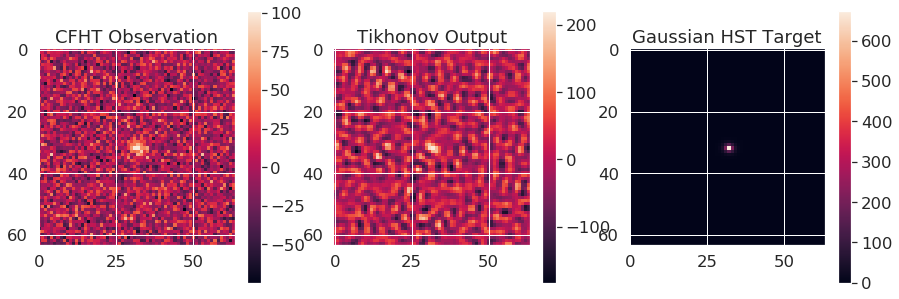

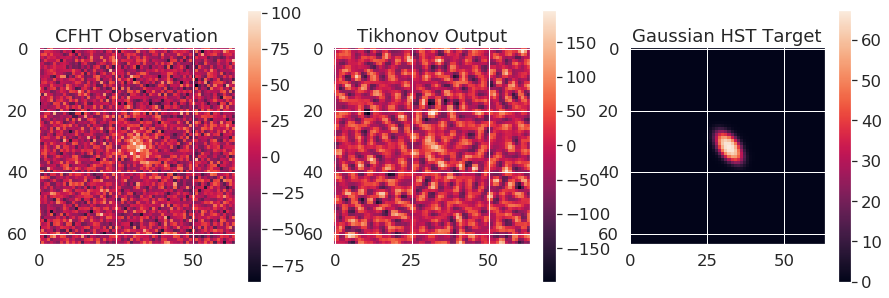

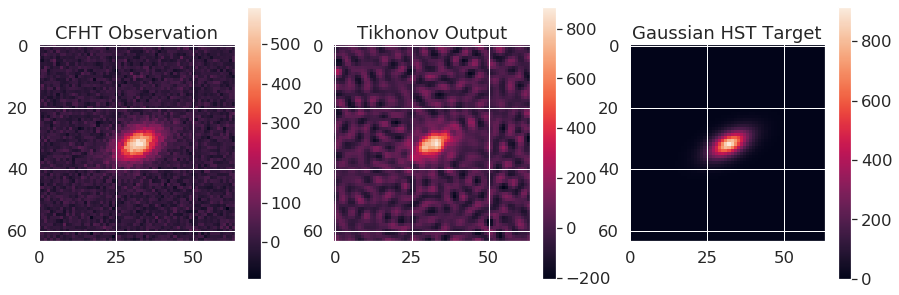

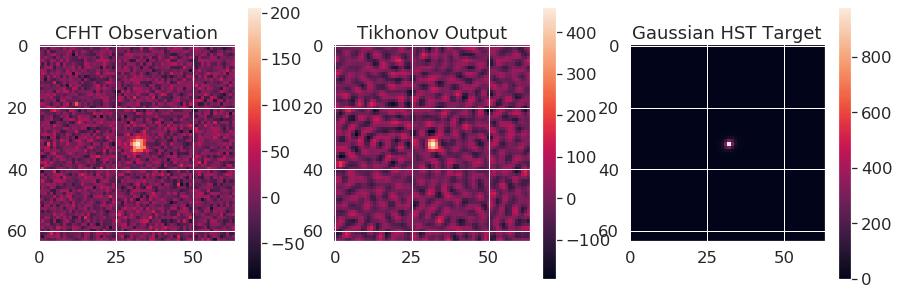

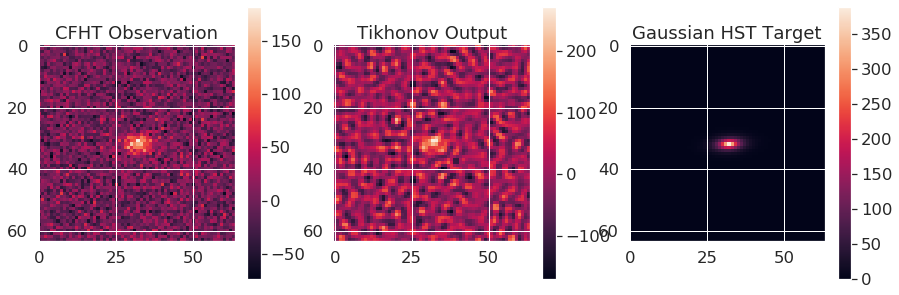

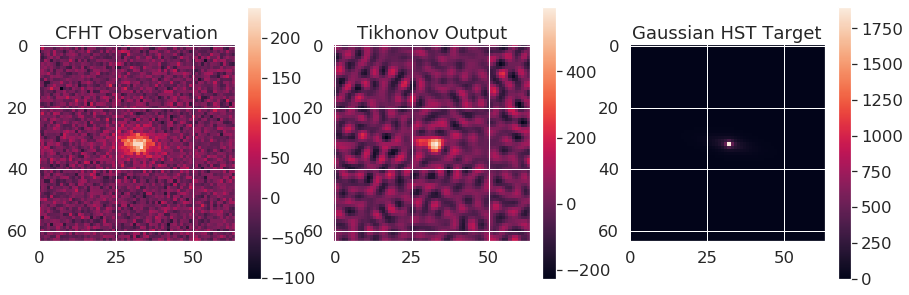

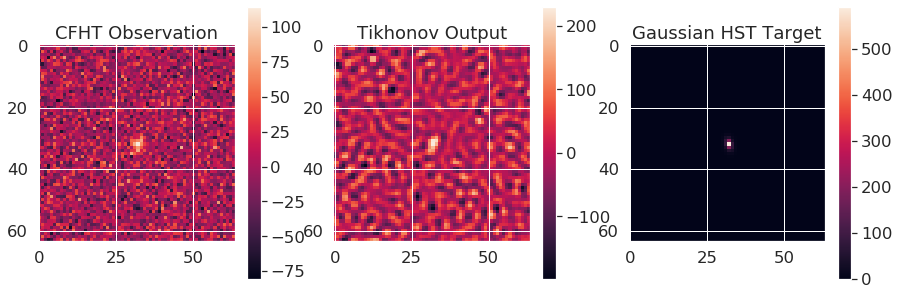

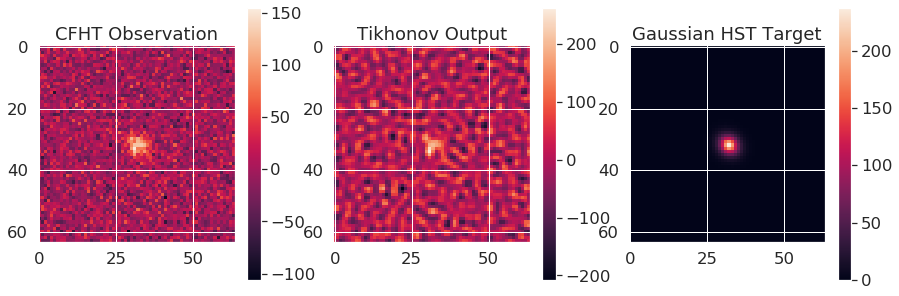

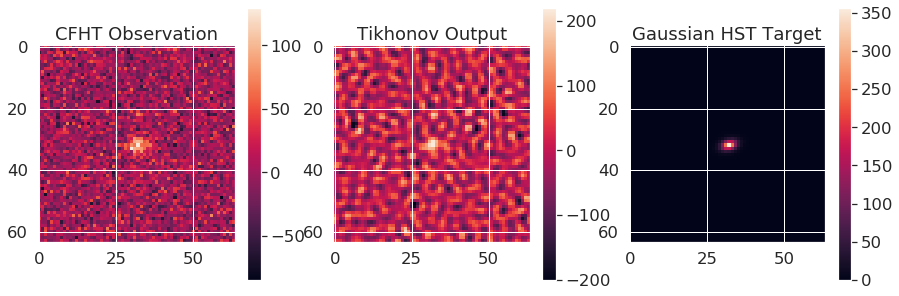

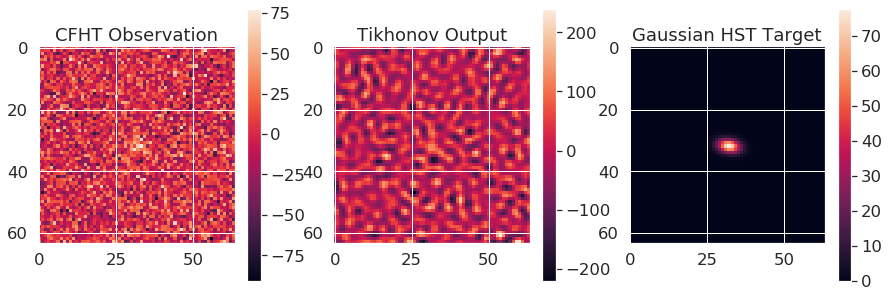

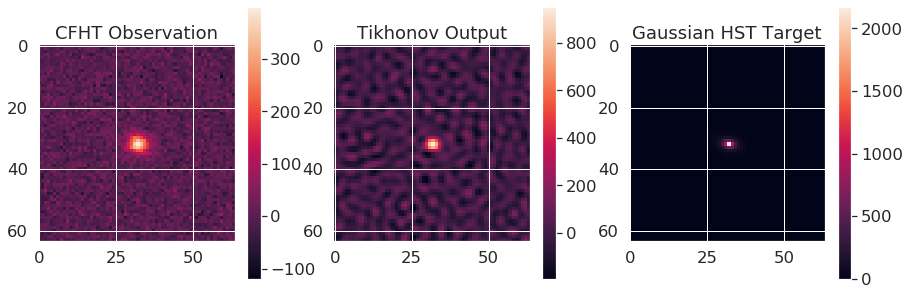

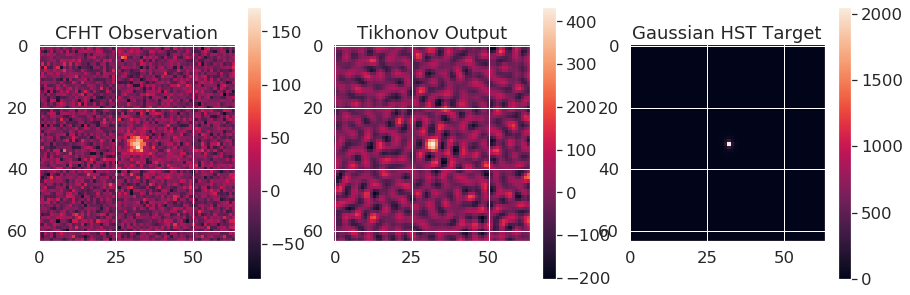

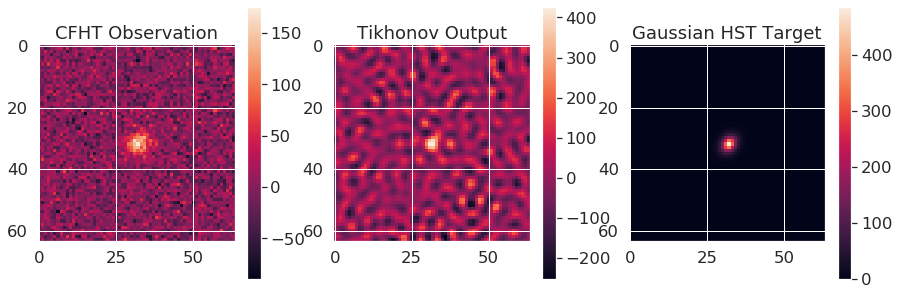

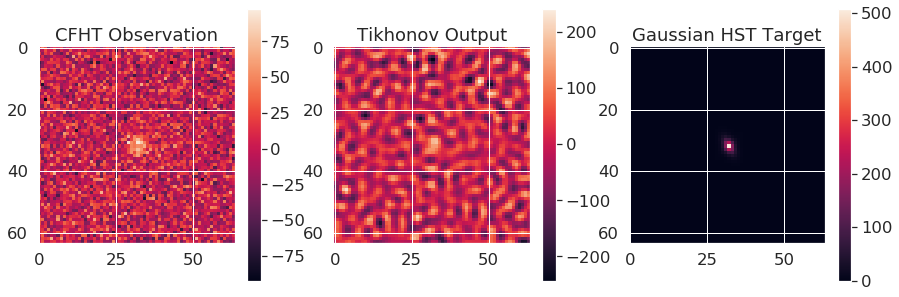

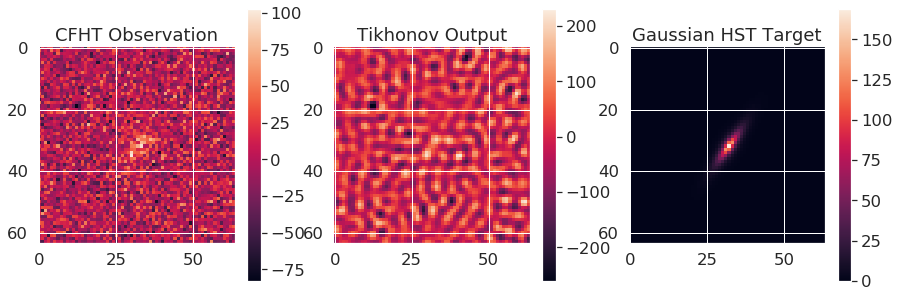

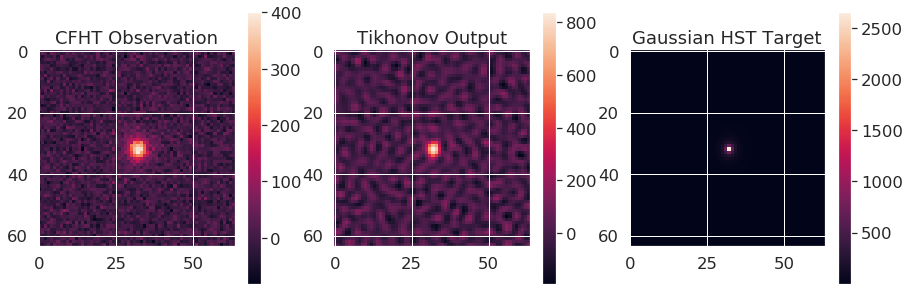

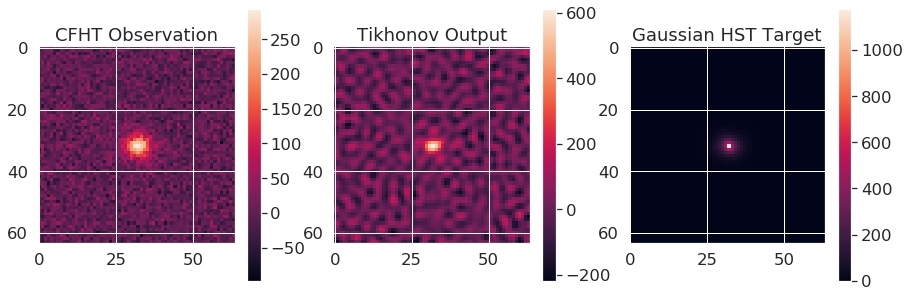

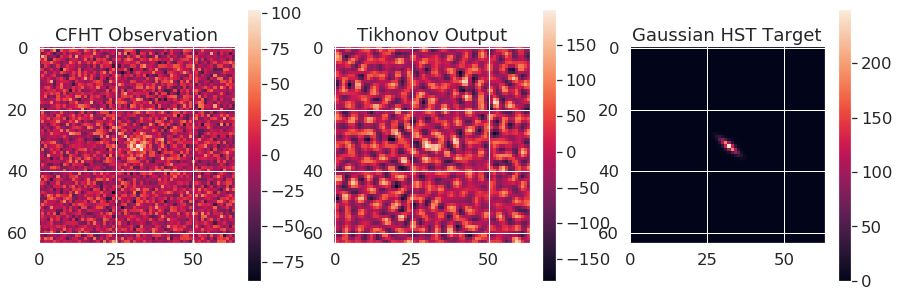

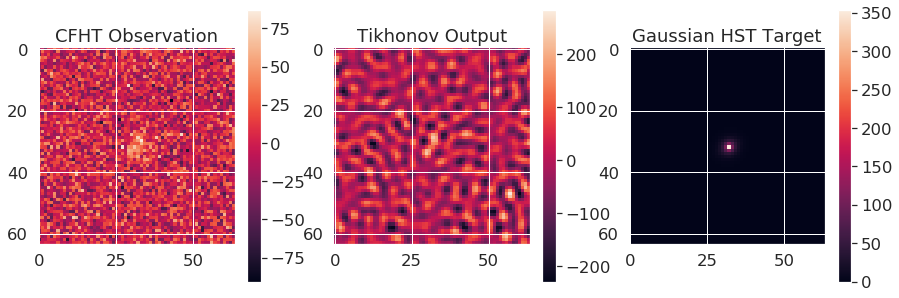

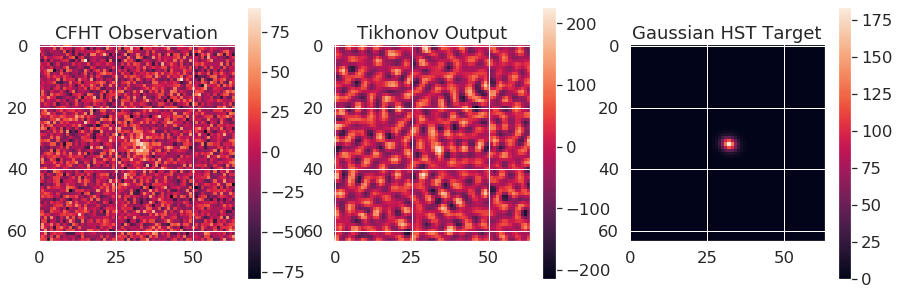

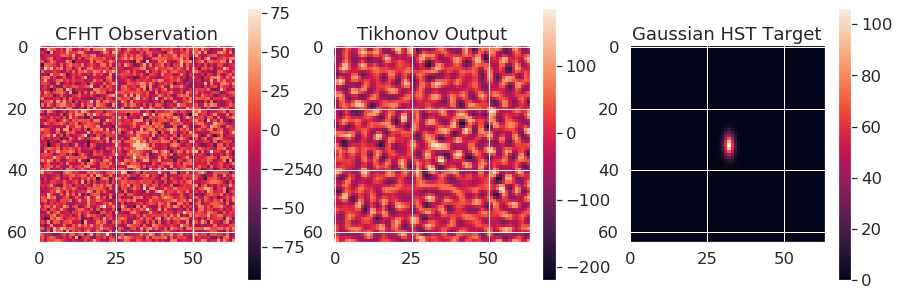

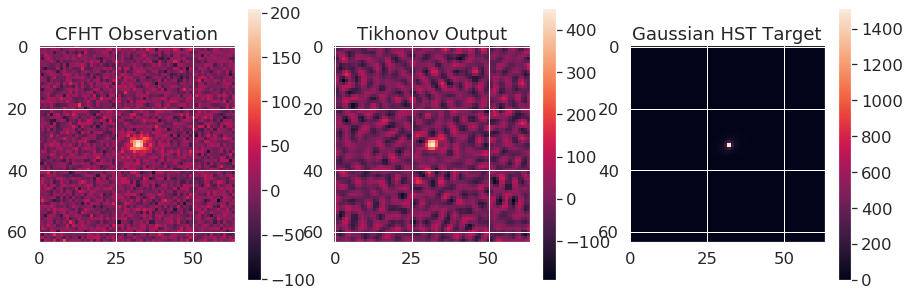

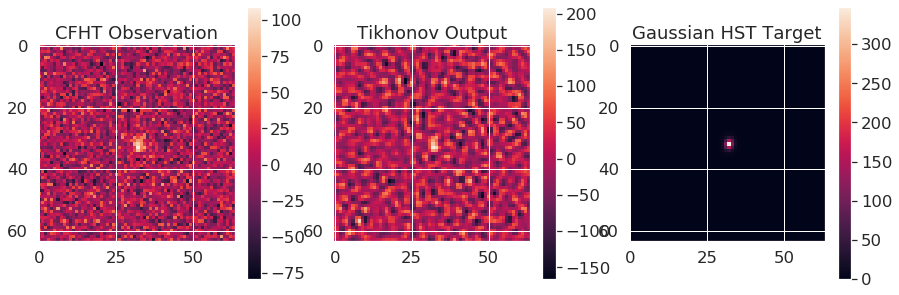

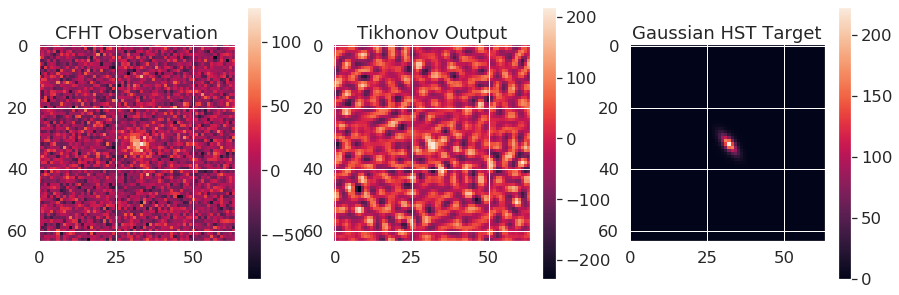

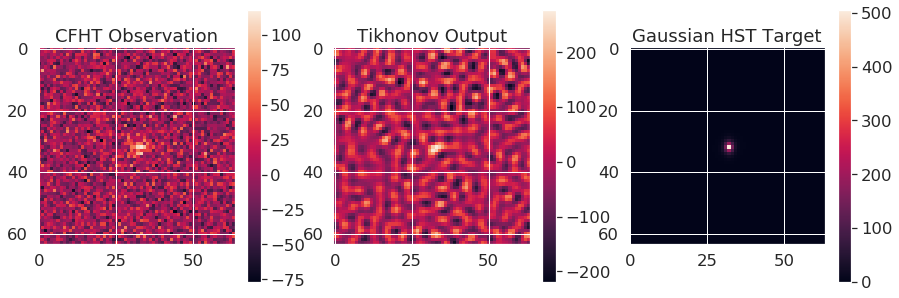

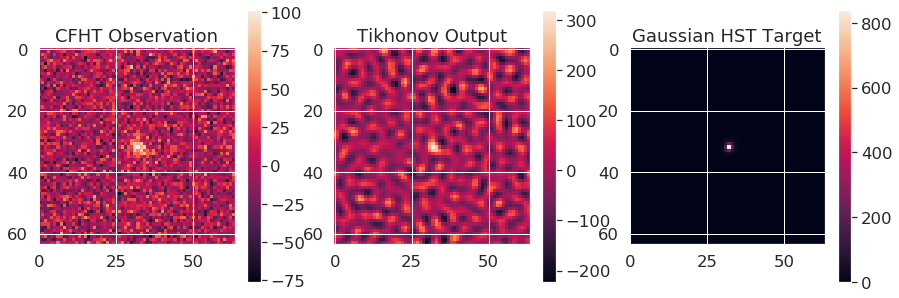

In [4]:
# set seaborn theme and style
sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for i in range(50):#n_batch):
    plt.figure(33,figsize=(15,5))
    plt.subplot(131)
    plt.imshow(batch['inputs'][i,...,0])
    plt.title('CFHT Observation')
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(batch['inputs_tikho'][i,...,0])
    plt.title('Tikhonov Output')
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(batch['targets'][i,...,0])
    plt.title('Gaussian HST Target')
    plt.colorbar()
    plt.show()

(array([2.991e+03, 5.500e+01, 1.100e+01, 7.000e+00, 6.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  152.9395,  2129.4634,  4105.9873,  6082.5107,  8059.0347,
        10035.559 , 12012.082 , 13988.606 , 15965.13  , 17941.654 ,
        19918.178 ], dtype=float32),
 <a list of 10 Patch objects>)

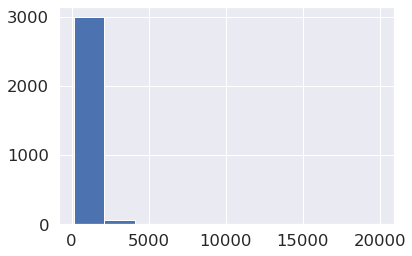

In [5]:
max_inten = np.array([np.max(np.abs(im)) for im in batch['inputs_tikho']])
plt.hist(max_inten)

<Figure size 432x288 with 0 Axes>

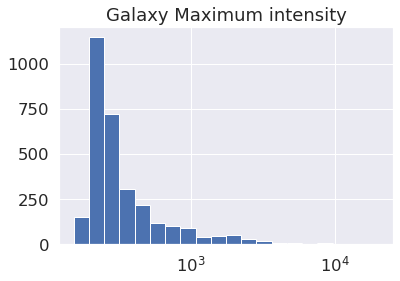

In [6]:
# histogram on linear scale
hist, hbins, _ = plt.hist(max_inten, bins=20)
plt.clf()
plt.figure(9876)
# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(hbins[0]),np.log10(hbins[-1]),len(hbins))
plt.hist(max_inten, bins=logbins)
plt.xscale('log')
plt.title(r'Galaxy Maximum intensity')
plt.show()

In [13]:
print('Maximal instesity peak : {}'.format(np.max(max_inten)))
print('Median instesity peak : {}'.format(np.median(max_inten)))
print('Mean instesity peak : {}'.format(np.mean(max_inten)))
print('99th percentile instesity peak : {}'.format(np.percentile(max_inten,99)))

Maximal instesity peak : 19918.177734375
Median instesity peak : 263.9066162109375
Mean instesity peak : 481.182861328125
99th percentile instesity peak : 3419.886596679687
